In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
a, b, c = 170, 170, 250

n_zs = 20
dist = c / (1.76*n_zs)

zs = np.linspace(-c+dist/2, c-dist/2, n_zs)

thetas = np.arcsin(zs/c)
av_rhos = (a + b) * np.cos(thetas) / 2
n_cells = np.ceil(av_rhos/dist).astype(np.int)

phis = np.concatenate(
    [np.linspace(-np.pi, np.pi,
                 nc, endpoint=False)
     + (np.pi/nc) * (i%2)
     for i, nc in enumerate(n_cells)])
zs = np.concatenate(
    [z * np.ones(nc)
     for z, nc in zip(zs, n_cells)])
thetas = np.concatenate(
    [theta * np.ones(nc)
     for theta, nc in zip(thetas, n_cells)])

xs = a * np.cos(thetas) * np.cos(phis)
ys = b * np.cos(thetas) * np.sin(phis)
print(zs.shape)

(376,)


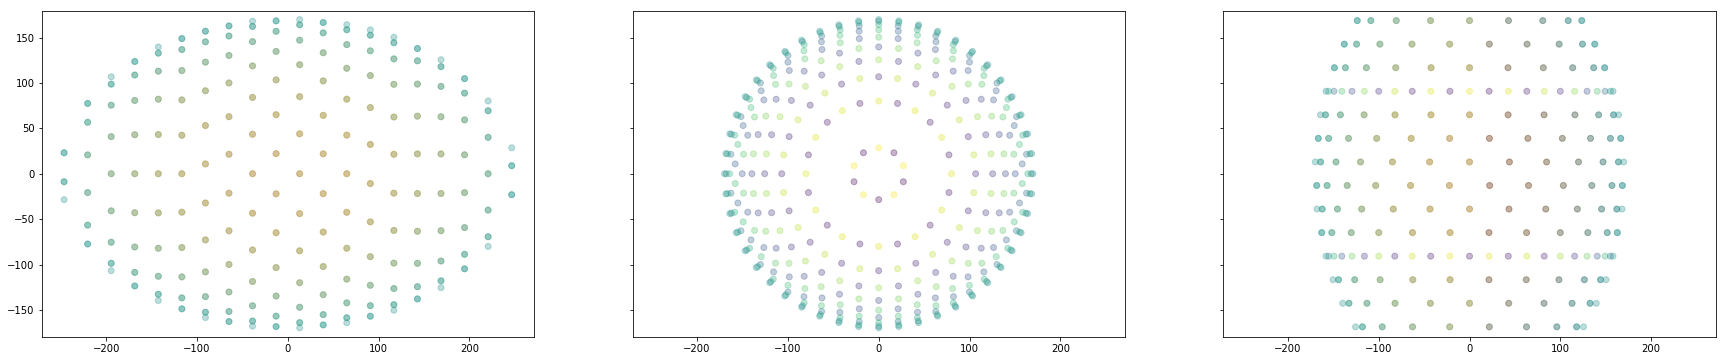

In [119]:
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True)


fig.set_size_inches(30, 6)
axes[0].scatter(zs, xs, c=ys,
                alpha=0.3)
axes[1].scatter(ys, xs, c=zs,
                alpha=0.3)
axes[2].scatter(ys, zs, c=xs,
                alpha=0.3)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

In [120]:
from scipy.spatial import Voronoi
from tyssue import Epithelium

from tyssue.core.generation import from_2d_voronoi
from tyssue import config
from tyssue.draw.threejs_draw import view_3js
from tyssue import SheetGeometry
from tyssue.core.objects import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw  

In [121]:
def get_subeptm(cond, coords):
    
    
    f_ids = np.arange(ys.size)
    points = np.vstack([xs[cond],
                        ys[cond],
                        zs[cond]]).T

    voro = Voronoi(points[:, coords[:2]])
    datasets = from_2d_voronoi(voro)

    eptm = Epithelium('3D_test', datasets,
                      config.geometry.spherical_sheet())
    eptm.face_df['z'] = points[:, coords[2]]
    eptm.face_df['f_ids'] = f_ids[cond]
    eptm.edge_df['f_ids'] = eptm.upcast_face(eptm.face_df['f_ids'])
    eptm.sanitize()
    eptm.edge_df['z'] = eptm.upcast_face(eptm.face_df['z'])
    eptm.vert_df['z'] = eptm.edge_df.groupby('srce')['z'].mean()
    coords = [list('xyz')[c] for c in coords]
    eptm.vert_df[['x', 'y', 'z']] = eptm.vert_df[coords]
    SheetGeometry.update_all(eptm)
    eptm.edge_df['opposite'] = get_opposite(eptm.edge_df)
    eptm.edge_df['opp_fids'] = eptm.edge_df.loc[
        eptm.edge_df['opposite'].values,
        'f_ids'].values.astype(np.int)
    
    for c in 'xyz':
        eptm.edge_df['s'+c] = eptm.upcast_srce(eptm.vert_df[c]) 
        eptm.edge_df['t'+c] = eptm.upcast_trgt(eptm.vert_df[c]) 
        
    return eptm

In [122]:
eptm_zpos = get_subeptm(zs>=0, [0, 1, 2])
eptm_zneg = get_subeptm(zs<=0, [0, 1, 2])
eptm_ypos = get_subeptm(ys>=0, [0, 2, 1])
eptm_yneg = get_subeptm(ys<=0, [0, 2, 1])
eptm_xpos = get_subeptm(xs>=0, [2, 1, 0])
eptm_xneg = get_subeptm(xs<=0, [2, 1, 0])



In [123]:
edge_df = pd.concat([eptm_zpos.edge_df.dropna(),
                     eptm_zneg.edge_df.dropna(),
                     eptm_ypos.edge_df.dropna(),
                     eptm_yneg.edge_df.dropna(),
                     eptm_xpos.edge_df.dropna(),
                     eptm_xneg.edge_df.dropna()],
                    ignore_index=True)

In [124]:
dups = edge_df[edge_df.duplicated(['f_ids', 'opp_fids'])].index

In [125]:
srce_pos = edge_df.groupby(['f_ids', 'opp_fids'])[['sx', 'sy', 'sz']].mean()
trgt_pos = edge_df.groupby(['f_ids', 'opp_fids'])[['tx', 'ty', 'tz']].mean()


In [126]:
srce_pos_tuple = edge_df.groupby(['f_ids', 'opp_fids'])['srce'].apply(frozenset)

(-200, 200)

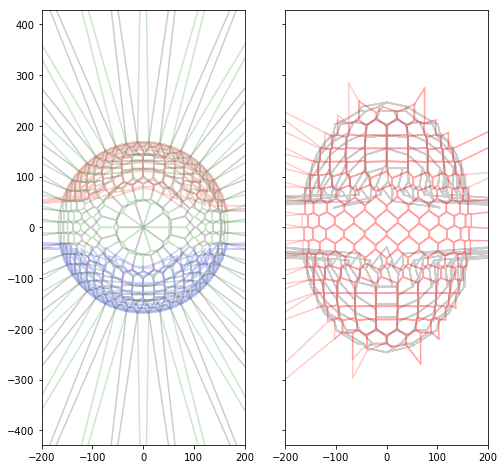

In [131]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
quick_edge_draw(eptm_zpos, ax=ax[0],
                c='k', alpha=0.2)
quick_edge_draw(eptm_zneg, ax=ax[1],
                c='k', alpha=0.2, coords=['x', 'z'])
quick_edge_draw(eptm_ypos, ax=ax[0],
                c='r', alpha=0.2)
quick_edge_draw(eptm_yneg, ax=ax[1],
                c='r', alpha=0.2, coords=['x', 'z'])
quick_edge_draw(eptm_zneg, ax=ax[0],
                c='g', alpha=0.2)
quick_edge_draw(eptm_zpos, ax=ax[1],
                c='k', alpha=0.2, coords=['x', 'z'])
quick_edge_draw(eptm_yneg, ax=ax[0],
                c='b', alpha=0.2)
quick_edge_draw(eptm_ypos, ax=ax[1],
                c='r', alpha=0.2, coords=['x', 'z'])


fig.set_size_inches((8,8))
ax[0].set_aspect('equal')
ax[0].set_xlim(-200, 200)

ax[0].set_ylim(-200, 200)
ax[1].set_xlim(-200, 200)

In [314]:
com_yn_zn = set(eptm_yneg.face_df['f_ids']).intersection(
    eptm_zneg.face_df['f_ids'])

In [315]:
com_yn_zn


{10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 

In [308]:
f_yn = eptm_yneg.face_df[eptm_yneg.face_df['f_ids'] == 115]
f_zn = eptm_zneg.face_df[eptm_zneg.face_df['f_ids'] == 115]

e_yn = eptm_yneg.edge_df[eptm_yneg.edge_df['f_ids'] == 115]
e_zn = eptm_zneg.edge_df[eptm_zneg.edge_df['f_ids'] == 115]
iv_yn = e_yn['srce'].values
iv_zn = e_zn['srce'].values

v_yn = eptm_yneg.vert_df.loc[iv_yn, list('xyz')]
v_zn = eptm_zneg.vert_df.loc[iv_zn, list('xyz')]


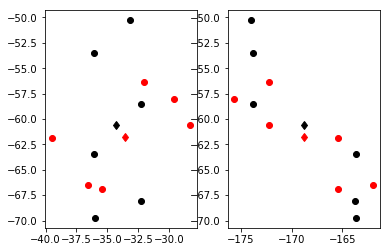

In [309]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(v_yn.x, v_yn.y, 'ko')
ax[0].plot(v_zn.x, v_zn.y, 'ro')
ax[0].plot(f_yn.x, f_yn.y, 'kd')
ax[0].plot(f_zn.x, f_zn.y, 'rd')

ax[1].plot(v_yn.z, v_yn.y, 'ko')
ax[1].plot(v_zn.z, v_zn.y, 'ro')
ax[1].plot(f_yn.z, f_yn.y, 'kd')
ax[1].plot(f_zn.z, f_zn.y, 'rd')



In [47]:
rdr, lines = view_3js(eptm_ypos)
rdr